<a href="https://colab.research.google.com/github/mkhokher/alzheimer-detetction-from-speech/blob/main/Alzheimer_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

AI based Detection of Alzheimer's disease throuh speech

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import make_scorer, accuracy_score, confusion_matrix, classification_report, f1_score, roc_auc_score

In [ ]:
feature_cols = [f'feat_{i}' for i in range(1, 27)]
train_cols   = ['subject_id'] + feature_cols + ['updrs', 'label']
test_cols    = ['subject_id'] + feature_cols + ['label']

In [ ]:
df_train = pd.read_csv("train_data.txt", header=None)
df_test = pd.read_csv("test_data.txt", header=None)

In [ ]:
df_train.drop(df_train.columns[-2], axis=1, inplace=True) # remove 1 column from train dataset which is not in test dataset
df_train.rename(columns={df_train.columns[-1]: df_test.columns[-1]}, inplace=True)

In [ ]:
df_combined = pd.concat([df_train, df_test], axis=0)
df_combined.drop(columns=[0], inplace=True) # drop subject_id column

In [ ]:
X = df_combined.iloc[:, :-1]
y = df_combined.iloc[:, -1]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)

## Custom Voting model

In [ ]:
svm_model = SVC(kernel='rbf', probability=True, max_iter=10000, tol=1e-3)
rf_model  = RandomForestClassifier(random_state=42)
knn_model = KNeighborsClassifier()

voting_clf = VotingClassifier(
    estimators=[
        ('svm', svm_model),
        ('rf',  rf_model),
        ('knn', knn_model)
    ],
    voting='soft'
)

In [ ]:
param_grid = {
    # SVM parameters
    'svm__C':        [0.1, 1.0, 10.0],
    'svm__gamma':    ['scale', 'auto', 0.01, 0.1],
    # Random Forest parameters
    'rf__n_estimators':    [100, 200, 300],
    'rf__max_depth':       [None, 5, 10],
    'rf__min_samples_leaf':[1, 2, 4],
    # KNN parameters
    'knn__n_neighbors': [3, 5, 7],
    'knn__metric':      ['euclidean', 'minkowski']
}

In [ ]:
grid = GridSearchCV(
    estimator=voting_clf,
    param_grid=param_grid,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=2
)

In [ ]:
grid.fit(X_train, y_train)

Fitting 5 folds for each of 1944 candidates, totalling 9720 fits
[CV] END knn__metric=euclidean, knn__n_neighbors=3, rf__max_depth=None, rf__min_samples_leaf=1, rf__n_estimators=100, svm__C=0.1, svm__gamma=scale; total time=   0.5s
[CV] END knn__metric=euclidean, knn__n_neighbors=3, rf__max_depth=None, rf__min_samples_leaf=1, rf__n_estimators=100, svm__C=0.1, svm__gamma=scale; total time=   0.5s
[CV] END knn__metric=euclidean, knn__n_neighbors=3, rf__max_depth=None, rf__min_samples_leaf=1, rf__n_estimators=100, svm__C=0.1, svm__gamma=auto; total time=   0.5s
[CV] END knn__metric=euclidean, knn__n_neighbors=3, rf__max_depth=None, rf__min_samples_leaf=1, rf__n_estimators=100, svm__C=0.1, svm__gamma=scale; total time=   0.5s
[CV] END knn__metric=euclidean, knn__n_neighbors=3, rf__max_depth=None, rf__min_samples_leaf=1, rf__n_estimators=100, svm__C=0.1, svm__gamma=scale; total time=   0.5s
[CV] END knn__metric=euclidean, knn__n_neighbors=3, rf__max_depth=None, rf__min_samples_leaf=1, rf__n

GridSearchCV(cv=5,
             estimator=VotingClassifier(estimators=[('svm',
                                                     SVC(max_iter=10000,
                                                         probability=True)),
                                                    ('rf',
                                                     RandomForestClassifier(random_state=42)),
                                                    ('knn',
                                                     KNeighborsClassifier())],
                                        voting='soft'),
             n_jobs=-1,
             param_grid={'knn__metric': ['euclidean', 'minkowski'],
                         'knn__n_neighbors': [3, 5, 7],
                         'rf__max_depth': [None, 5, 10],
                         'rf__min_samples_leaf': [1, 2, 4],
                         'rf__n_estimators': [100, 200, 300],
                         'svm__C': [0.1, 1.0, 10.0],
                         'svm__gamma': ['scale', 'auto', 0.01, 0.1]},
             scoring='f1', verbose=2)

In [ ]:
best_voting = grid.best_estimator_

y_test_pred = best_voting.predict(X_test)
y_test_prob = best_voting.predict_proba(X_test)[:, 1]
accuracy_vot = accuracy_score(y_test, y_test_pred)
f1_vot = f1_score(y_test, y_test_pred)
roc_auc_vot = roc_auc_score(y_test, y_test_prob)

print("Test Accuracy: ", accuracy_vot)
print("F1 Score: ", f1_vot)
print("AUC-ROC: ", roc_auc_vot)

print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))
print("Classification Report:\n", classification_report(y_test, y_test_pred))

Test Accuracy:  0.7107438016528925
F1 Score:  0.75
AUC-ROC:  0.7851867335562989
Confusion Matrix:
 [[ 67  37]
 [ 33 105]]
Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.64      0.66       104
           1       0.74      0.76      0.75       138

    accuracy                           0.71       242
   macro avg       0.70      0.70      0.70       242
weighted avg       0.71      0.71      0.71       242



## Gradient Boosting:

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

In [ ]:
xgb_model = XGBClassifier(
    n_estimators=100,
    max_depth=4,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

In [ ]:
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, ...)

In [ ]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'gamma': [0, 1, 5],
    'min_child_weight': [1, 5, 10]

}

grid = GridSearchCV(XGBClassifier(random_state=42), param_grid, cv=5, scoring='f1', verbose=2, n_jobs=-1)

In [ ]:
grid.fit(X_train, y_train)

Fitting 5 folds for each of 432 candidates, totalling 2160 fits
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_de

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, feature_weights=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=Non...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.8, 1.0], 'gamma': [0, 1, 5],
                         'learning_rate': [0.01, 0.1], 'max_depth': [3, 4, 5],
                         'min_child_weight': [1, 5, 10],
                         'n_estimators': [100, 200], 'subsample': [0.8, 1.0]},
             scoring='f1', verbose=2)

In [ ]:
best_xgb = grid.best_estimator_
y_test_pred = best_xgb.predict(X_test)

In [ ]:
y_test_proba = best_xgb.predict_proba(X_test)[:, 1]

accuracy_gb = accuracy_score(y_test, y_test_pred)
f1_gb = f1_score(y_test, y_test_pred)
roc_auc_gb = roc_auc_score(y_test, y_test_proba)
print("Test Accuracy: ", accuracy_score(y_test, y_test_pred))
print("F1 Score: ", f1_score(y_test, y_test_pred))
print("AUC-ROC: ", roc_auc_score(y_test, y_test_proba))

print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))
print("Classification Report:\n", classification_report(y_test, y_test_pred))


Test Accuracy:  0.7148760330578512
F1 Score:  0.7472527472527473
AUC-ROC:  0.8069258639910813
Confusion Matrix:
 [[ 71  33]
 [ 36 102]]
Classification Report:
               precision    recall  f1-score   support

           0       0.66      0.68      0.67       104
           1       0.76      0.74      0.75       138

    accuracy                           0.71       242
   macro avg       0.71      0.71      0.71       242
weighted avg       0.72      0.71      0.72       242



## Custom stacking model:

In [ ]:
estimators = [
    ('rf', RandomForestClassifier(n_estimators=200, max_depth=10, min_samples_leaf=2, random_state=42)),
    ('svm', make_pipeline(StandardScaler(), SVC(probability=True, kernel='rbf', C=10.0, gamma='scale'))),
    ('xgb', XGBClassifier(n_estimators=100, max_depth=4, learning_rate=0.1, subsample=1.0, random_state=42))
]

In [ ]:
stacking_clf = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(),
    cv=5,
    passthrough=False,
    n_jobs=-1
)

In [ ]:
param_grid = {
    'rf__n_estimators': [100, 200],
    'rf__max_depth': [5, 10],
    'svm__svc__C': [1, 10],
    'svm__svc__gamma': ['scale', 0.1],
    'xgb__n_estimators': [100, 200],
    'xgb__max_depth': [3, 5],
    'final_estimator__C': [0.1, 1, 10]
}

grid = GridSearchCV(estimator=stacking_clf, param_grid=param_grid,
                    cv=5, scoring='f1', verbose=2, n_jobs=-1)

In [ ]:
grid.fit(X_train, y_train)

Fitting 5 folds for each of 192 candidates, totalling 960 fits
[CV] END final_estimator__C=0.1, rf__max_depth=5, rf__n_estimators=100, svm__svc__C=1, svm__svc__gamma=scale, xgb__max_depth=3, xgb__n_estimators=100; total time=   2.7s
[CV] END final_estimator__C=0.1, rf__max_depth=5, rf__n_estimators=100, svm__svc__C=1, svm__svc__gamma=scale, xgb__max_depth=3, xgb__n_estimators=100; total time=   2.7s
[CV] END final_estimator__C=0.1, rf__max_depth=5, rf__n_estimators=100, svm__svc__C=1, svm__svc__gamma=scale, xgb__max_depth=3, xgb__n_estimators=100; total time=   2.7s
[CV] END final_estimator__C=0.1, rf__max_depth=5, rf__n_estimators=100, svm__svc__C=1, svm__svc__gamma=scale, xgb__max_depth=3, xgb__n_estimators=100; total time=   2.7s
[CV] END final_estimator__C=0.1, rf__max_depth=5, rf__n_estimators=100, svm__svc__C=1, svm__svc__gamma=scale, xgb__max_depth=3, xgb__n_estimators=100; total time=   2.7s
[CV] END final_estimator__C=0.1, rf__max_depth=5, rf__n_estimators=100, svm__svc__C=1, 

GridSearchCV(cv=5,
             estimator=StackingClassifier(cv=5,
                                          estimators=[('rf',
                                                       RandomForestClassifier(max_depth=10,
                                                                              min_samples_leaf=2,
                                                                              n_estimators=200,
                                                                              random_state=42)),
                                                      ('svm',
                                                       Pipeline(steps=[('standardscaler',
                                                                        StandardScaler()),
                                                                       ('svc',
                                                                        SVC(C=10.0,
                                                                            probability=True))])),
                                                      ('xgb',
                                                       XGBClassifier(base_score=None,
                                                                     booster=None,
                                                                     callbacks=None,
                                                                     colsample_bylevel=None,
                                                                     col...
                                                                     multi_strategy=None,
                                                                     n_estimators=100,
                                                                     n_jobs=None,
                                                                     num_parallel_tree=None, ...))],
                                          final_estimator=LogisticRegression(),
                                          n_jobs=-1),
             n_jobs=-1,
             param_grid={'final_estimator__C': [0.1, 1, 10],
                         'rf__max_depth': [5, 10],
                         'rf__n_estimators': [100, 200], 'svm__svc__C': [1, 10],
                         'svm__svc__gamma': ['scale', 0.1],
                         'xgb__max_depth': [3, 5],
                         'xgb__n_estimators': [100, 200]},
             scoring='f1', verbose=2)

In [ ]:
best_stack = grid.best_estimator_

y_pred = best_stack.predict(X_test)
y_proba = best_stack.predict_proba(X_test)[:, 1]
accuracy_stack = accuracy_score(y_test, y_pred)
f1_stack = f1_score(y_test, y_pred)
roc_auc_stack = roc_auc_score(y_test, y_proba)
print("Test Accuracy: ", accuracy_score(y_test, y_pred))
print("F1 Score: ", f1_score(y_test, y_pred))
print("AUC-ROC: ", roc_auc_score(y_test, y_proba))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Test Accuracy:  0.7272727272727273
F1 Score:  0.7591240875912408
AUC-ROC:  0.8083890746934225
Confusion Matrix:
 [[ 72  32]
 [ 34 104]]
Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.69      0.69       104
           1       0.76      0.75      0.76       138

    accuracy                           0.73       242
   macro avg       0.72      0.72      0.72       242
weighted avg       0.73      0.73      0.73       242



## Plots for performances of different models

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

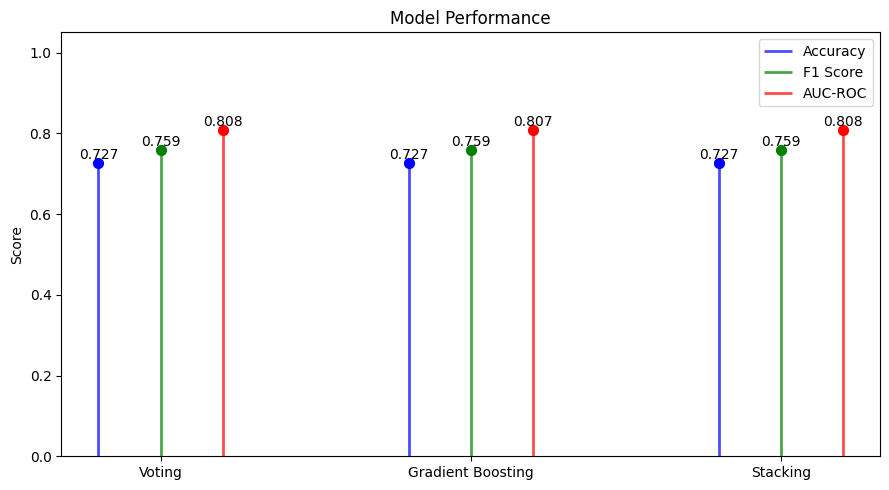

In [ ]:
plt.figure(figsize=(9, 5))


def lollipop(x, y, label, color):
    plt.vlines(x, 0, y, colors=color, alpha=0.7, linewidth=2, label=label)
    plt.scatter(x, y, color=color, s=50)

lollipop(x - 0.2, accuracy, 'Accuracy', 'blue')
lollipop(x, f1, 'F1 Score', 'green')
lollipop(x + 0.2, auc, 'AUC-ROC', 'red')

for i in range(len(x)):
    plt.text(x[i]-0.2, accuracy[i]+0.01, f"{accuracy[i]:.3f}", ha='center')
    plt.text(x[i], f1[i]+0.01, f"{f1[i]:.3f}", ha='center')
    plt.text(x[i]+0.2, auc[i]+0.01, f"{auc[i]:.3f}", ha='center')

plt.xticks(x, models)
plt.ylabel('Score')
plt.title('Model Performance')
plt.ylim(0, 1.05)
plt.legend()
plt.tight_layout()
plt.show()
